<h1 align='center'> CIFAR-10 Classification </h1>
**Gye Hyun Baek (gb2508) <br>
Euiyoung Chung (ec3243) <br>
Young Cho Lee (yl3794) <br>**


## Outline:

1. [**Introduction**](#intro) <br><br>
2. [**Data Preparation**](#prep)<br>
a) Importing Data<br>
b) Normalization<br>
c) Stratified Split<br><br>
3. [**Modeling**](#model)<br>
a) Logistic Regression<br>
b) Trying Multiple Models<br>
c) Hyperparameter Tuning <br>
d) Convolutional Neural Networks: **plain training** and **data augmentation**<br><br>
4. [**Evaluation**](#eval)<br>
b) Confusion Matrix<br>
c) Error Analysis



# Report Description

## Goals:

- This project aims to explore different classification algorithms to classify CIFAR-10 pictures. Especially, we focused on testing the hypothesis that using convolutional neural networks outperforms conventional algorithms such as SVM or random forest. 

## Results:

- Despite extensive algorithm selection and hyperparameter tuning, convolutional neural networks achieved a far better performance compared to the conventional algorithms.

## Key Successes:

- A great deal of flexibility could be both an advantage and disadvantage of neural networks. It allows the model to learn highly sophisticated structure behind the features. On the other hand, it also makes the model overfit the data with less ability to be generalized. We have applied **data augmentation** to enhance the performance of our neural network.
- Even though the performance of neural networks is impressive, the performance is not the only thing that matters in building models. It is almost impossible to interpret neural networks as the models work like a black box. I applied comprehensive random search to identify the best model among the collection of traditional algorithms. 


## Key Challenges:

- One of the most challenging characteristics of the data was the high dimensionality. Despite the relatively small dimension compared to other image data, CIFAR-10 still has almost a thousand columns. This makes it hard to train multiple models. One single logistic regression took us more than two hours to train.
- Due to the same characteristic, it was not easy to find a fine balance between bias and variance. Ideally, the best model should be flexible enough to represent the critical information of training data as well as not too flexible to suffer from high variance. When it comes to the conventional algorithms, regularization parameters came in handy. One the other hand, tweaking the architecture of neural networks was an art more than engineering. We applied many different architectures, dropout layers, and batch normalization layers to balance bias and variance.


## Key Insights:

- In terms of the final CNN model, it is interesting to know that similar looking objects and animals tend to be misclassified as each other by the model. This is evidence that CNN can interpret the shapes and details.  
- It should not be assumed that a certain algorithm works always better than the others. As we observed in the multiple learning curves, random forest and SVM seems to overfit the data easily. Without these plots and metrics, it is easy to suppose that bagging algorithms are better for a classification of high dimensional data. Model selection should be done by monitoring the metrics and graphs, not by personal belief.

## What is the next step?:

- It would be worth to try more advanced architectures for the neural networks. A residual neural network is a good example. 
- It may be possible to transform similar objects and animals into more distinguishable matrices. That is why the last error analysis was insightful.
- The size of the data was quite small compared to the regular image processing dataset. It would be interesting to train our model on CIFAR-100 and compare the performance with CIFAR-10. The model can be more calibrated to work better on a massive amount of data.


Finally, regardless of format, please do include in your report a written description of the project goals and results.  You can also (optionally) include some description of key successes, key challenges, key insights you've had, and possible next steps (what you might have done with more time). 

In [1]:
# Warning off
from warnings import filterwarnings
filterwarnings('ignore')

# Data Wrangling & visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Basic Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# Neural Network Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
import tensorflow as tf

# Neural Network Keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.initializers import he_normal
from scipy.stats.mstats import zscore

plt.style.use('fivethirtyeight')
%matplotlib inline

# etc.
import os

Using TensorFlow backend.


<a id='intro'></a>
# 1. Introduction
## Data Descriptions:

The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

## Key Concepts & Directions:

We will compare performance of different algorithms and different ways of feature engineering.

<a id='prep'></a>
# 2. Data Preparation

## a) Importing Data

In [2]:
def unpickle(file):
    ''' This Function is to import CIFAR-10 data 
    '''
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
#path = r'C:\Users\leeyo\OneDrive\Documents\Columbia Univ\Advanced Machine Learning\Team Project\Image Dataset\cifar-10-batches-py' 
#path = 'content/drive/Shared with me/Projects/ML/data'
fnames = [name + str(num) for name, num in zip(['data_batch_']*5, range(1,6))] + ['test_batch']

df = []
label = []

for fname in fnames:
    data = unpickle(fname)
    df.append(np.array(data[b'data']))
    label.append(np.array(data[b'labels']))
    
df = np.concatenate(df)
label = np.concatenate(label)

In [3]:
# How to standardized?
print("Range of pixel values: {} ~ {}".format(df.min().min(), df.max().max()))

Range of pixel values: 0 ~ 255


<br>
## b) Normalization

** Reasons behind it **
- During the back propagation, we would like to ensure similar ranges for all feature so that gradients will be kept under control. Same reasoning applies to fitting logistic regression.
- Convolutional Neural Network is layers of shared weights. Thus, if we don't scale each feature to equal scale, it could deteriorate its performance.

In [4]:
# Min-max Normalization
df = df/255

In [5]:
# Standardization
#df = scaler(df)

In [6]:
print(df.shape)
print(label.shape)

(60000, 3072)
(60000,)


<br>
## c) Stratified Split

** What is a stratified split? **

- Instead of splitting our dataset with randomly generated index or sampling without replacement, we maintain equal portion for each class. Results are verified **below**.


In [7]:
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=test_ratio, stratify=label, random_state=42)

In [8]:
def stratified_visual(label):
    orig_labels = {5:'dog', 6:'frog', 9:'truck', 4:'deer', 1:'automobile', 2:'bird', 7:'horse', 8:'ship', 3:'cat', 0:'airplane'}
    for i in range(10):
        print("Label {} or {} represents about ".format(i, orig_labels[i]) + str((sum(label == i)/len(label))) + "\n")

# Storing copies for future usage
temp_y_test = y_test.copy().reshape(-1,1)
temp_y_train = y_train.copy()

In [9]:
print(X_train.shape)
print(y_train.shape)

(48000, 3072)
(48000,)


In [10]:
print("Test set..\n")
stratified_visual(y_test)

Test set..

Label 0 or airplane represents about 0.1

Label 1 or automobile represents about 0.1

Label 2 or bird represents about 0.1

Label 3 or cat represents about 0.1

Label 4 or deer represents about 0.1

Label 5 or dog represents about 0.1

Label 6 or frog represents about 0.1

Label 7 or horse represents about 0.1

Label 8 or ship represents about 0.1

Label 9 or truck represents about 0.1



<br>
<br>
<a id='model'></a>
# 3. Modeling

## a) Logistic Regression

First, We will try to fit a logistic regression with a default setting. Logistic regression is a very simple kind of neural network. Cross validation is a desirable way to evaluate the performance of classifiers. In addition, here we set up a relatively unusual scoring parameter. F1 score is a harmonic mean of recall and precision. This metrics is far more reliable than accuracy if there exists an imbalance of classes in the data. In this case, our multi-class data have almost the same number of examples for each class. This is also guaranteed by stratified sampling.

** Findings **

- Logistic regression is a binary classifier in nature. However, there are multiple ways to make it a multi-class classifier. In this case, scikit-learn automatically detects multi-class in the data and generalize the logistic regression by the one-vs-the-rest scheme. 
- We will use stratified 3-fold cross-validation to evaluation the performance of a plain logistic regression initially without a hyperparameter tuning.

In [11]:
# Stratified Cross-validation
kfold = StratifiedKFold(n_splits=3, random_state=42)
lr = LogisticRegression()

# Fit the model
acc_val = cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=kfold)
acc_mean = np.mean(acc_val)

print('validation accuracy: {}'.format(round(acc_mean, 3)))

validation accuracy: 0.403


## What is happening?

- This metrics does not tell much about what is happening under the hood. How about the variance or bias of the classifier? We do not have much evidence to detect over-fitting or under-fitting. That is why learning curves come in handy.

### Findings

- Based on the graph, this logistic regression has underfitted the data with a high bias. This is due to the lack of the flexibility of the model. Adding more training samples is not likely to increase the performance.

### There are several ways to enhance the performance in case of underfitting.

- Use more flexible models<br>
- Reduce noise<br>
- Reduce regularization terms<br>
- Ensemble multiple classifiers, possible of the same kind.

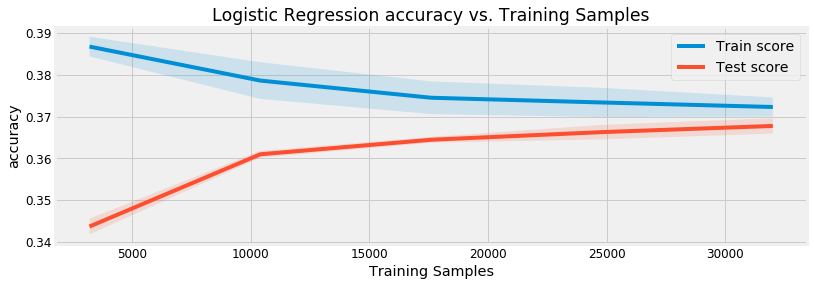

In [11]:
from sklearn.model_selection import learning_curve

def call_plot(xaxis, train_scores, test_scores, name_pred, name_param, scoring):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.rcParams['font.size'] = 12
    plt.figure(figsize=(12,4))
    plt.plot(xaxis, train_scores_mean, label='Train score')
    plt.plot(xaxis, test_scores_mean, label='Test score')
    plt.fill_between(xaxis, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.15)
    plt.fill_between(xaxis, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.15)
    plt.legend(fontsize=14)
    plt.xlabel(name_param)
    plt.ylabel(scoring)
    plt.title("{} {} vs. {}".format(name_pred, scoring, name_param))
    plt.show()
    
def plot_learning_curve(predictor, X, y, name_param, name_pred, scoring='accuracy', cv=3):
    train_sizes, train_scores, test_scores = learning_curve(predictor, X, y, scoring=scoring, cv=cv)
    call_plot(train_sizes, train_scores, test_scores, name_pred, name_param, scoring)

lr = LogisticRegression()
plot_learning_curve(lr, X_train, y_train, "Training Samples", "Logistic Regression", scoring="accuracy")

<br>
## b) Trying Multiple Models

- As I detected high bias in the logistic regression, I will continue to compare more flexible models to identify the best performing one.

### Approaches:

- I used 10% of the training samples as it will take an unreasonable amount of time to train all these models with a commercial lap-top setting. As learning curve gives a good representation of the performance, this portion is enough to give a useful insight.

### Findings:

- **KNN**: high bias and medium variance. Low training score represents underfitting and the gap between the training score and validation score indicates variance.
- **NB**: High bias and low variance. It is unlikely that adding more training samples to the model will increase the model performance better than 40%.
- **Random Forest**: Very high variance, low bias. This is a typical example of overfitting. The model perfectly classified the training points but cannot be generalized to the unseen data.
- **XGboosting**: Low bias and medium variance. This model seems to work the best in this setting of limited sample size. It is likely that training on more samples will eventually make XG boosting the best model.
- **Support Vector Machine**: High variance and low bias. The graph looks similar with random forest for the same reasons.

#### Note: adding more samples to RF or SVM might make them outperform XGboosting in the end. However, based on the trade-off of time cost and accuracy, we have made an optimal point at using 10% of the sample. 

In [12]:
# Note this is allowed as we shuffled the data by train_test_split
n_sampling = len(X_train)//10
short_X_train = X_train[:n_sampling]
short_y_train = y_train[:n_sampling]

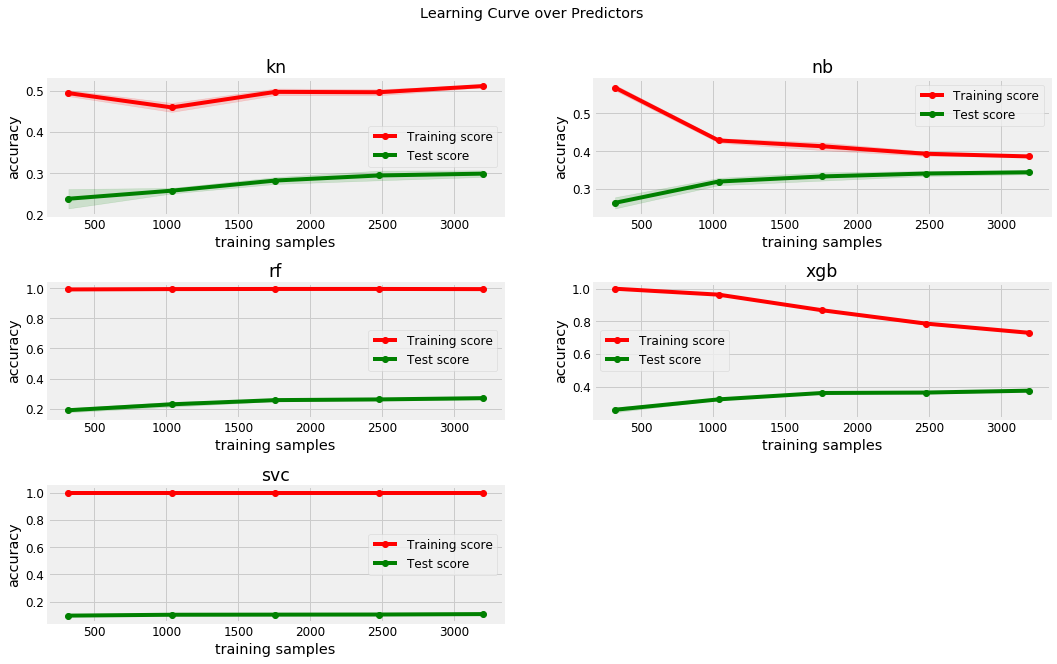

In [13]:
def plot_multiple_learning_curve(preds, X, y, title='', figsize=(13, 5), names=[], scoring='accuracy', cv=3):
    '''
    Calling learning curve plots for multiple predictors.
    Learning curves are good indicators of overfitting or underfitting.
    
    '''
    n_pred = len(preds)
    
    train_scores = {}
    test_scores = {}
    
    for i, pred in enumerate(preds):
        train_sizes, train_scores[names[i]], test_scores[names[i]] = learning_curve(pred, X, y, 
                                                                                    scoring=scoring, cv=cv)
    

    plt.rcParams['font.size'] = 12
    
    n_col = 2
    n_row = int(np.ceil(n_pred/2)) 
    does_last_exist = bool(n_pred%2) 
    
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize, sharex=False, sharey=False)
    if does_last_exist:
        fig.delaxes(axs[n_row-1, 1])
    
    axs = axs.ravel()
    axs = axs[:-1] if does_last_exist else axs
    
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axs):
        mean_train_scores = np.mean(train_scores[names[i]], axis=1)
        mean_test_scores = np.mean(test_scores[names[i]], axis=1)
        std_train_scores = np.std(train_scores[names[i]], axis=1)
        std_test_scores = np.std(test_scores[names[i]], axis=1)
        
        ax.plot(train_sizes, mean_train_scores, 'o-', color='r',
                  label='Training score')
        ax.plot(train_sizes, mean_test_scores, 'o-', color='g',
                  label='Test score')
        ax.fill_between(train_sizes, mean_train_scores - std_train_scores,
                          mean_train_scores + std_train_scores, alpha=0.15, color='r')
        ax.fill_between(train_sizes, mean_test_scores - std_test_scores,
                          mean_test_scores + std_test_scores, alpha=0.15, color='g')
        ax.legend(loc='best')
        ax.set_xlabel('training samples')
        ax.set_ylabel(scoring)
        ax.set_title(names[i])
    

predictors = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), 
              XGBClassifier(), SVC(decision_function_shape='ovo')]
pred_names = ['kn', 'nb', 'rf', 'xgb', 'svc']

plot_multiple_learning_curve(predictors, short_X_train, short_y_train, figsize=(16, 10), 
                              title='Learning Curve over Predictors', names=pred_names, scoring='accuracy', cv=3)

<br>
## c) Hyperparameter tuning

### Approaches 

- It turned out that XGboosting is the best fit for the data based on the learning curves. I will try to identify the best parameter combination for a XGBoosting model.

### Findings

- Even after the thorough hyperparameter tuning, the performance of XGboosting is not satisfying with around 45% accuracy.
- We need more flexible models!

In [13]:
# XGBoost
xg_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xg = XGBClassifier()
xg_rs = RandomizedSearchCV(xg, xg_param_grid, 
                                   n_iter=50, scoring='accuracy', 
                                   n_jobs=-1, cv=2, verbose=3)
xg_rs.fit(X_train, y_train)

print("XGboosting best accuracy: {}", xg_rs.best_score_)

XGboosting best accuracy: 0.452


<br>
## d) Convolutional Neural Networks

- Finally, we are about to try one of the most flexible tools in machine learning. Neural network is a chain of functions to map an numeric input into outputs. 
- We explore two different architectures of CNN: **Initial model** and **data augmentation model**

** Data Cleaning: **
- In order to fit the data to two dimensional convolutional layers, each observation should be transformed into three dimensional tensors.

In [14]:
def make_tensors(df):
    n_channel = 3 # number of channels:3 (blue, green, red)
    n_col = 32*32 # number of columns for each channel
    image_size = 32 #  #number of pixels for each edge (32 * 32 size)
    
    new_df = np.zeros((df.shape[0], image_size, image_size, n_channel))
    
    for n in range(n_channel):
        new_df[:, :, :, n] = df[:, n_col*n:n_col*(n+1)].reshape((-1, image_size, image_size))
    
    return new_df

def one_hot_encode(label):
    oh = OneHotEncoder()
    return oh.fit_transform(label), oh

def mapping_label(label):
    labels = {5:'dog', 6:'frog', 9:'truck', 4:'deer', 
              1:'automobile', 2:'bird', 7:'horse',
              8:'ship', 3:'cat', 0:'airplane'}
    return labels[label]

In [15]:
# Dim
n_channel = 3 # number of channels:3 (blue, green, red)
image_size = 32 #number of pixels for each edge (32 * 32 size)

input_shape = [image_size, image_size, n_channel]

# Reshape
X_train, X_test = make_tensors(X_train), make_tensors(X_test)

# Encode
(y_train, _), (y_test, _) = one_hot_encode(y_train[:,np.newaxis]), one_hot_encode(y_test[:, np.newaxis])

#### Restoring an image
Imported raw dataset was a flatted image. To construct our convolutional neural network, we reshaped 1D vector to 2D image. Below is to verify our work.

Shown image below is a dog.


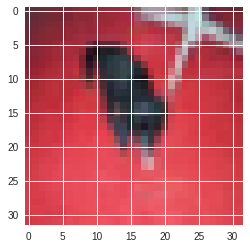

In [0]:
index_image = 18
plt.imshow(X_test[index_image])
print("Shown image below is a " + str(mapping_label(temp_y_test[index_image,0])) + '.')

## CNN models outline:
Two different implementation of CNN architectures are explored. The Inital model is implemented in **Tensorflow** and the Data Augmentation part is implemented in **Keras**.

##### Layers: 
- Conv -> Dropout -> Conv -> Max Pooling -> Dropout -> Conv -> Conv -> Max Pooling -> Dropout -> Conv -> Conv -> Max Pooling -> Dropout -> Fully Connected Nodes

##### Dropout: 
- To address overfitting, we add drop out layers after 1st, 2nd, 4th, 6th convolution layers.

##### Initialization: 
- If the weights from simple random initialization start too small, signals shrink as they pass through each layer. On the other hand, if the weights are too large, signals grow exponentially as they pass through each layer.

##### He normalization (He et al. 2015).
- He normalization draws samples from a truncated normal distribution with $\mu$ of 0 and $\sigma$ of $\sqrt{2/n}$, where n is defined as size of input units. We chose this initialization because it was proven to be effective with **ReLu** activation.

##### Weight Decay
- It is very unlikely that our network will be stuck at local minima (because it would mean each feature's gradient is pointing at the same direction all at once); however, with controlled number of epochs, we can prevent our model from overfitting to the training datasets. For Ver 2, we monitor its learning rate and if validation loss doesn't improve for 5 epochs, we reduce learning rate by factor of 10.

**Note** <br>
As mentioned above, we have two different versions for our CNN. To reproduce each model, only run cells that are relevant to each model.

In [25]:
def build_CNN_classifier(x, model_name):
    if model_name == "Ver 1":
        x_image = x

        # Conv 1th layer
        W_conv1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 3, 64], stddev=5e-2))
        b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
        h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

        h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

        # 2nd layer
        W_conv2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 64, 64], stddev=5e-2))
        b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

        h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

        # 3rd layer
        W_conv3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], stddev=5e-2))
        b_conv3 = tf.Variable(tf.constant(0.1, shape=[128]))
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3)

        # 4th layer
        W_conv4 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 128], stddev=5e-2))
        b_conv4 = tf.Variable(tf.constant(0.1, shape=[128])) 
        h_conv4 = tf.nn.relu(tf.nn.conv2d(h_conv3, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4)

        # 5th layer
        W_conv5 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 128], stddev=5e-2))
        b_conv5 = tf.Variable(tf.constant(0.1, shape=[128]))
        h_conv5 = tf.nn.relu(tf.nn.conv2d(h_conv4, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + b_conv5)

        # 1th fully-connected layer
        W_fc1 = tf.Variable(tf.truncated_normal(shape=[8 * 8 * 128, 384], stddev=5e-2))
        b_fc1 = tf.Variable(tf.constant(0.1, shape=[384]))

        # Flatten
        h_conv5_flat = tf.reshape(h_conv5, [-1, 8*8*128])
        h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

        # Drop-out
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) 

        # Output layer
        W_fc2 = tf.Variable(tf.truncated_normal(shape=[384, 10], stddev=5e-2))
        b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
        logits = tf.matmul(h_fc1_drop,W_fc2) + b_fc2
        y_pred = tf.nn.softmax(logits)
        return y_pred, logits
        
    if model_name == "Ver 2":
        num_classes = 10
        num_filter = 64
        seed = 64
        input_shape = x.shape[1:]
        drop_out_rate = 0.3
        kernel_size = 3
        model = Sequential()
        # He normalization for relu
        
        # First convolutional layer
        model.add(Conv2D(num_filter, kernel_size, padding='valid', input_shape= input_shape, kernel_initializer = 'he_normal', bias_initializer = 'zeros'))
        # Input layer has 64 neurons or kernels and kernel size is 3 by 3
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out_rate))
        # Since we are inputting raw images, we add dropout layer to constraint our model from being exposed to different noises or meaningless feature.
        
        # Second convolutional layer
        model.add(Conv2D(num_filter, kernel_size, padding='valid'))
        # We don't use padding for the second convolutional layer. Based on our visual inspection, our targets were mostly located at the center
        # Thus we will force our model to focus on features that are closer to the center.
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        # Learning low level features
        model.add(Dropout(drop_out_rate - 0.1))

        # Third convolutional layer
        model.add(Conv2D(2*num_filter, kernel_size, padding='same'))
        # We increase number of neurons while keeping kernel size as the same. We think that at this stage of our network, it should start learning
        # representations of multiple low level features combined
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        # Batch Normalization is added at the end of each layer so that our network becomes more robust. Also, it helps the following layer's
        # procedure
        
        # Fourth convolutional layer
        # Started increasing kernel_size. It allows our network to see a wider picture
        model.add(Conv2D(2*num_filter, kernel_size + 2, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(drop_out_rate))
        # Also, since we increased number of neurons starting from third convolutional layer, we added another dropout.
        
        # Fifth convolutional layer
        model.add(Conv2D(4*num_filter, kernel_size + 2, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        # Sixth convolutional layer
        model.add(Conv2D(4*num_filter, kernel_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(drop_out_rate + 0.1))
        # Dropout right before fully connected layer
        
        model.add(Flatten())
        model.add(Dense(num_classes, activation='softmax'))
        # Softmax to generate probabilities for each class
        
        return model
        # Note that Ver 2 returns an object. Ver 1 returns y_pred and logits.
        # If you want to reproduce our work, please run different chunk of codes (commented below)

    

<br>

In [26]:
def next_batch(num, data, labels):
    ''' This function returns a single batch for each call
    '''
    m = num
    
    permutation = list(np.random.permutation(m))
    
    shuffled_data = data[permutation, :]
    shuffled_label = labels[permutation, :].toarray()
    
    return (shuffled_data, shuffled_label)

In [ ]:
# Input, output placeholders
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='x')
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
keep_prob = tf.placeholder(tf.float32)

# Graph called
y_pred, logits = build_CNN_classifier(x, "Ver 1")

# Loss defined
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

# Train
train_step = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

# Accuray metrics
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [28]:
n_batch = 64
n_iter = 500
history = [[],[]]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_iter):
        batch = next_batch(n_batch, X_train, y_train)
        sess.run(train_step, feed_dict={x: batch[0], y: batch[1], keep_prob: 0.8})
        
        if (i+1) % 5 == 0 and i != 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
            loss_print = loss.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
            #val_accuray = accuracy.eval(feed_dict={x: X_test, y: y_test.toarray(), keep_prob: 1.0})
            
            # For loss plot
            history[0].append(i)
            history[1].append(loss_print)
            
            if (i+1) % 10 == 0:
                print("iteration {} - loss: {:.3f}, train_acc: {:.3f}".format(i+1, loss_print, train_accuracy))
        
    test_accuracy = 0.0
    
    for i in range(10):
        test_batch = next_batch(X_test.shape[0]//10, X_test, y_test)
        test_accuracy += accuracy.eval(feed_dict={x: test_batch[0], y: test_batch[1], keep_prob: 1.0})
        
    test_accuracy /= 10;

print("{} iterations over\n test accuracy: {}".format(n_iter, test_accuracy))

iteration 10 - loss: 2.173, train_acc: 0.188
iteration 20 - loss: 2.092, train_acc: 0.219
iteration 30 - loss: 1.997, train_acc: 0.422
iteration 40 - loss: 1.953, train_acc: 0.438
iteration 50 - loss: 2.172, train_acc: 0.203
iteration 60 - loss: 2.009, train_acc: 0.266
iteration 70 - loss: 1.684, train_acc: 0.578
iteration 80 - loss: 2.165, train_acc: 0.281
iteration 90 - loss: 2.473, train_acc: 0.125
iteration 100 - loss: 2.061, train_acc: 0.375
iteration 110 - loss: 2.060, train_acc: 0.375
iteration 120 - loss: 1.072, train_acc: 0.703
iteration 130 - loss: 0.589, train_acc: 0.797
iteration 140 - loss: 0.453, train_acc: 0.891
iteration 150 - loss: 0.009, train_acc: 1.000
iteration 160 - loss: 0.007, train_acc: 1.000
iteration 170 - loss: 0.000, train_acc: 1.000
iteration 180 - loss: 1.072, train_acc: 0.703
iteration 190 - loss: 0.004, train_acc: 1.000
iteration 200 - loss: 0.001, train_acc: 1.000
iteration 210 - loss: 0.000, train_acc: 1.000
iteration 220 - loss: 0.000, train_acc: 1.0

Text(0,0.5,'loss')

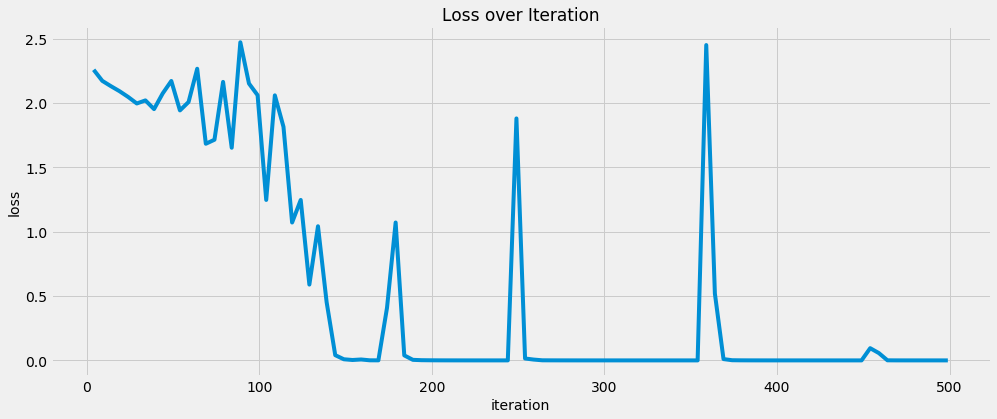

In [30]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,6))
sns.lineplot(history[0], history[1])
plt.title('Loss over Iteration', fontsize=17)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('loss', fontsize=14)

## Insights from the Loss Function

- As the training starts, the model`s training accuracy quickly approaches 100%. This is a good example of overfitting. The models perfectly represent the training data but cannot necessarily be generalized to the unseen dataset.
- You see the sudden spikes in the middle of the training. That indicates that the models is not likely to be generalized if the characteristics of a batch changes slightly.
- We will deal with this overffiting behavior in the following section.

<br>
## d) Data Augumentation: 

##### Approaches:
- Overfitting could be caused by having too few samples to learn from, rendering us unable to train a model that can generalize to new data. Ideally, if our model was exposed to infinite number of data, it would be able to learn every possible aspect of the data distribution, however, this is not the case. Data augmentation takes the idea of generating more training data from existing training samples, by augmenting samples via number of transformations. In our case, we utilize ImageDataGenerator and generate artificial training sets through flippling, or rotating. etc.


In [16]:
def train_data_augmentation():
    datagen = ImageDataGenerator(
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True
    )
    return datagen
# Image augmentation as mentioned above.
def z_score(train, test):
    mean = np.mean(train,axis=(0,1,2,3))
    std = np.std(train,axis=(0,1,2,3))
    x_train = (train - mean)/(std+1e-7)
    x_test = (test - mean)/(std+1e-7)
    return x_train, x_test
# We decided not to use z_score 

In [17]:
#filePath = r'C:\Users\leeyo\OneDrive\Documents\Columbia Univ\Advanced Machine Learning\Team Project\Model\ver_2.h5'
callbacks_list = [ModelCheckpoint(filepath = 'ver_2.h5', monitor='val_loss', save_best_only = True), 
                  EarlyStopping(monitor = 'acc', patience = 5), 
                  ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5)]
model = build_CNN_classifier(X_train, "Ver 2")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
__________

In [20]:
# Training Phase
# z_score
#keras_train, keras_test = z_score(X_train, X_test)

keras_train_label, keras_test_label = to_categorical(temp_y_train), to_categorical(temp_y_test)
datagen = train_data_augmentation()
batch_size = 64
epochs = 500
learning_rate = 0.003
opt_adam = optimizers.adam(lr = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
model.compile(optimizer = opt_adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(datagen.flow(X_train, keras_train_label, batch_size = batch_size), 
                    steps_per_epoch = X_train.shape[0] // batch_size,
                   epochs = epochs, verbose=2, validation_data = (X_test, keras_test_label), callbacks = callbacks_list)

Epoch 1/500
 - 49s - loss: 1.8458 - acc: 0.4260 - val_loss: 1.7397 - val_acc: 0.4103
Epoch 2/500
 - 48s - loss: 1.5010 - acc: 0.4941 - val_loss: 1.3766 - val_acc: 0.5122
Epoch 3/500
 - 48s - loss: 1.1510 - acc: 0.5866 - val_loss: 1.0455 - val_acc: 0.6453
Epoch 4/500
 - 48s - loss: 1.0369 - acc: 0.6333 - val_loss: 1.4590 - val_acc: 0.6104
Epoch 5/500
 - 48s - loss: 0.9208 - acc: 0.6744 - val_loss: 0.8403 - val_acc: 0.7159
Epoch 6/500
 - 48s - loss: 0.9852 - acc: 0.6558 - val_loss: 0.9685 - val_acc: 0.6820
Epoch 7/500
 - 48s - loss: 0.8651 - acc: 0.6964 - val_loss: 0.9820 - val_acc: 0.6973
Epoch 8/500
 - 48s - loss: 0.7950 - acc: 0.7228 - val_loss: 0.8160 - val_acc: 0.7438
Epoch 9/500
 - 48s - loss: 0.7662 - acc: 0.7352 - val_loss: 0.7310 - val_acc: 0.7652
Epoch 10/500
 - 48s - loss: 0.7213 - acc: 0.7481 - val_loss: 0.8207 - val_acc: 0.7428
Epoch 11/500
 - 48s - loss: 0.6925 - acc: 0.7606 - val_loss: 1.8089 - val_acc: 0.6776
Epoch 12/500
 - 48s - loss: 0.6681 - acc: 0.7695 - val_loss: 0.

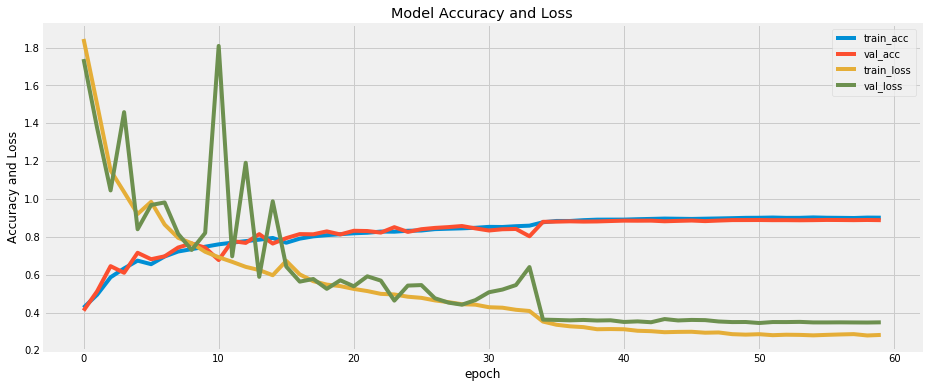

In [24]:
fig = plt.figure(figsize=(14, 6))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='best')

plt.show()

Inspecting **Model Accuracy and Loss** plot presented above, our model has learned features from raw images and exhibit a decent performance. Validation loss fluctuates because the input is a series of mini-batches. It is obvious that the fluctuation is not as erratic as the loss function from the initial model. (some mini batch could be highly biased relative to the test set, if we were performing batch gradient descent, it should be a problem).

<br>
<br>
<a id='eval'></a>
# 4. Evaluation

## a) Confusion Matrix

** Why does it matter? **

- In general, monitoring accuracy as the only metrics is not a good practice for building a classifier. It can be extremely misleading, for example, if there is the imbalance in the classes. 
- There is no imbalance in CIFAR-10 data. However, we decided to call a confusion matrix in order to make sure the accuracy metrics works properly.

** Findings **

- The classifier does not highly lean towards a subset of the classes. This can be accepted as a good example of using the accuracy metrics. 
- Even so, there are several errors that stand out. It is not due to the accuracy metrics, but to the resemblance between the objects or animals.


Accuracy : 0.8883333333333333
Classification Report
              precision    recall  f1-score   support

           0     0.9067    0.8992    0.9029      1200
           1     0.9465    0.9583    0.9524      1200
           2     0.8627    0.8533    0.8580      1200
           3     0.8051    0.7575    0.7806      1200
           4     0.9049    0.8567    0.8801      1200
           5     0.8551    0.7867    0.8194      1200
           6     0.8488    0.9450    0.8943      1200
           7     0.9043    0.9292    0.9166      1200
           8     0.9447    0.9400    0.9424      1200
           9     0.9005    0.9575    0.9281      1200

   micro avg     0.8883    0.8883    0.8883     12000
   macro avg     0.8879    0.8883    0.8875     12000
weighted avg     0.8879    0.8883    0.8875     12000



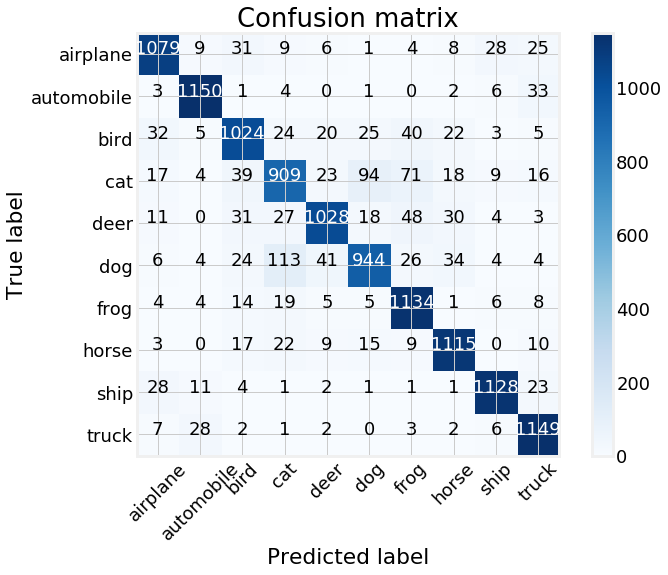

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

# Full-Report
def plot_confusion_mat(cm, classes, cmap=plt.cm.Blues):
    title='Confusion matrix'
    
    plt.rcParams['font.size'] = 18
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def full_report(model, x, y_true, classes):
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x)
    y_true = y_true

    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true, y_pred)))
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    #print(cnf_matrix)
    plot_confusion_mat(cnf_matrix, classes=classes)  

label_names = ['airplane', 'automobile', 'bird', 'cat', 
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
full_report(model, X_test, y_test_class, label_names)

<br>
## b) Error Analysis

** Findings **

- Normalized confusion plots provide an interesting view on our model`s performance. It turned out that dogs are often mis-predicted to be a cat. Birds tend to be misclassified to be an airplane. Cats are misclassified to be a dog or frog mostly.
- This analysis helps us get better insights about why the errors occur. It is possible to build an algorithm that differentiates pictures of cats and dogs for the model to achieve a better performance. Based on this observation, we can enhance our understanding of the model.

Text(0.5,0,'Predicted label')

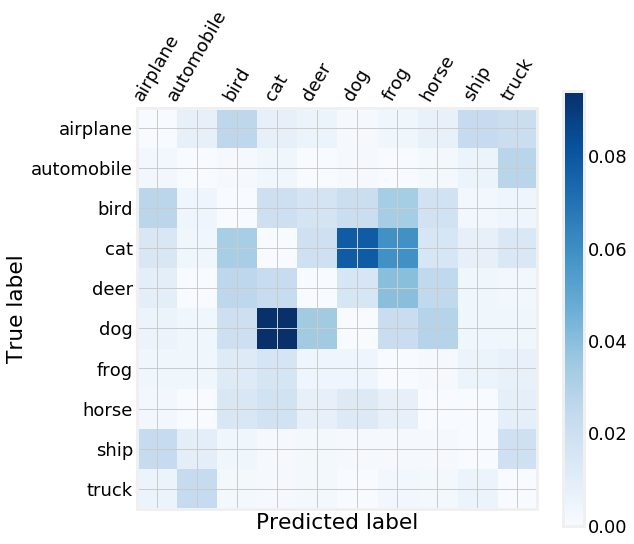

In [34]:
# Confusion Matrix - test
y_pred = model.predict_classes(X_test)
conf_mx = confusion_matrix(y_test_class, y_pred)

def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

# Closer look on errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx)

tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=60)
plt.yticks(tick_marks, label_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')